In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch.nn.utils.prune as prune
import torch.quantization
import matplotlib.pyplot as plt
import os
import torch.quantization
from PIL import Image

c:\Users\user\anaconda3\envs\summarizerP39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# number of images to be remembered by the network          |  img_res_hrzt
number_of_images = 250 # set as I                           |     _______
# the vertical resolution of the image                      |    |      |___
image_res_vert = 256 # set as V                             |    * * * *   |
# the horizontal resolution of the image                    |    * * * *   |  img_res_vert
image_res_hrzt = 256 # set as H                             |    * * * * __|


# to get optimal performance before pruning we need the network to weigh exactly like the images

# single image weight:
# H * V                           <--- number of pixels in that image
# weight of all images:
# H * V * I                       <--- number of pixels per image * how many images are there

# weight of the neural network weights:
# input layer * middle layer + middle layer * output layer
# since:
#     input layer = I (number of images)
#     middle layer = X (we need to find it)
#     output layer = H * V (we output a single image)

# weight of biases in the neural network:
# input layer + middle layer + output layer (every neurone has 1 bias)

# the total weight of the network:

#  weights      biases
#  ___|____   _____|____
# |       |  |         |
# IX + XHV + I + X + HV

# since we want to match the total weight of the network to the total weight of the images we compare them:

#   weight of network   weight of images
#  __________|__________   _|_
# |                    |  |  |
# IX + XHV + I + X + HV = IHV

# solve for X (size of middle layer):

# X = (HIV - I - HV) / (I + HV + 1)

#               ^
#               |
#               |

# this is the exact size of the middle layer to make the neural network weigh as much as the images do

In [3]:
# this is the class of the neural network that is going to be memorizing everything
class Memorizer(nn.Module):
    # network architecture:
    
    #                       number of images                                 |
    #                          (embedding)                                   |
    #              ________________|__________________                       |
    #             |                                  |                       |
    #             . . . . . . . .      . . . . . . . .                       |
    #                                                                        |
    #                           mid layer                                    |
    #                            (linear)                                    |
    #                    ___________|___________                             |
    #                   |                      |                             |
    #                   . . . . .      . . . . .                             |
    #                                                                        |
    #                      vertical * horizontal                             |
    #                            (linear)                                    |
    #          _____________________|_____________________                   |
    #         |                                          |                   |
    #         . . . . . . . . . .      . . . . . . . . . .                   V
    
    
    def __init__(self):
        super(Memorizer, self).__init__()
        # calculating the size of the middle layer based on the explanation above
        mid_layer = int((number_of_images * image_res_vert * image_res_hrzt - number_of_images - image_res_vert * image_res_hrzt) / (number_of_images + image_res_vert * image_res_hrzt + 1))
        
        # embeddings layer because the network takes in the index of the file that we want to recover
        self.em = nn.Embedding(number_of_images, mid_layer)
        # middle layer (without it it would be mathematically impossible to make the network weigh less than the images)
        self.fc1 = nn.Linear(mid_layer, mid_layer)
        # output layer (supposted to load the image back)
        self.fc2 = nn.Linear(mid_layer, image_res_vert*image_res_hrzt)
        
        # the layers we will be prunning later on
        self.prune_targets = [self.fc1, self.fc2]

    def forward(self, x):
        # these activation functions result in best performance
        x = self.em(x)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        
        return x

# move the network to the GPU (highly recommended because CPU overfitting is extremly slow)
memorizer = Memorizer()
GPU = torch.device("cuda")
memorizer.to(GPU)

Memorizer(
  (em): Embedding(250, 248)
  (fc1): Linear(in_features=248, out_features=248, bias=True)
  (fc2): Linear(in_features=248, out_features=65536, bias=True)
)

In [4]:
# MSEloss() and BCEloss() can be both used
loss = nn.BCELoss()
# such a small learning rate is in place to prevent image merging (when two images merge together into one on top of the other)
optimizer = optim.Adam(memorizer.parameters(), lr=0.0005)

In [5]:
# load the image in grayscale and normalize it
def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((image_res_vert, image_res_hrzt))
    img = img.convert("L")
    img_array = np.array(img)
    img_array = img_array.flatten()
    img_tensor = torch.tensor(img_array, dtype=torch.float32)
    img_tensor = img_tensor / 255.0

    return img_tensor

In [6]:
# display an image
def display_image(img_array):
    img_array = np.array(img_array)
    img_array = img_array.reshape(image_res_vert, image_res_hrzt)
    img_array = (img_array + 1) / 2
    plt.imshow(img_array)
    plt.show()

In [7]:
# function to pass over the network once
def train_nn(question_tensor, answer_tensor, model, loss, optimizer):
    optimizer.zero_grad()
    outputs = model(question_tensor)
    loss = loss(outputs, answer_tensor)
    loss.backward()
    optimizer.step()

In [8]:
# move a list of tensors to the GPU
def ltGPU(lst):
    for x in range(len(lst)):
        lst[x] = lst[x].to(GPU)

In [9]:
# load a certain number of images from the directory specified (change it to match yours)
files = os.listdir(r"C:\Users\user\Desktop\simulation\tooki\NETMEM github repo\NETMEM\animal parrot")[:number_of_images]

# we will train the network over these lists
questions = []
answers = []

# loop over the files loaded in the first line of the cell and load them into the lists
for x in range(len(files)):
    # the networks questions (whats on the input) is an int (for the embedding layer)
    questions.append(torch.tensor(x, dtype=torch.int))
    # the output is a tensor of the image associated with that spcific index
    answers.append(load_image(fr"C:\Users\user\Desktop\simulation\tooki\NETMEM github repo\NETMEM\animal parrot\{files[x]}"))

# move both lists to the GPU to train the network faster
ltGPU(questions)
ltGPU(answers)

In [26]:
# such a high number of passes over the dataset paired with a super low LR is recomended to minimize corruption
for x in tqdm(range(1000)):
    for y in range(len(questions)):
        train_nn(questions[y], answers[y], memorizer, loss, optimizer)

100%|██████████| 1000/1000 [27:58<00:00,  1.68s/it]


In [34]:
params_count = 0
pruned_count = 0
params_size = 4 # size of float32 parameter in bytes

for name, param in memorizer.named_parameters():
    if 'weight' in name:
        params_count += param.numel()
        pruned_count += torch.sum(param != 0)

pruned_size = params_size * pruned_count.item() / (1024 * 1024)
print(f"network weight: {pruned_size:.2f} MB")

network weight: 53.14 MB


In [35]:
tensor_size = image_res_vert*image_res_hrzt * 4 # size of float32 parameter in bytes
total_size = number_of_images * tensor_size
total_size = total_size / (1024 * 1024)
print(f"image weight: {total_size:.2f} MB")

image weight: 62.50 MB


In [33]:
# prune the network to actually make it lighter than the images
pruning_method = prune.L1Unstructured
# i found that prunning anything higher than 13 requires some kind of denoiser
pruning_amount = 0.15

for target in memorizer.prune_targets:
    prune.l1_unstructured(target, name='weight', amount=pruning_amount)

for target in memorizer.prune_targets:
    prune.remove(target, name='weight')

In [48]:
# a value to scroll over the images
rnd = 0

image number: 6
image remembered by memorizer:



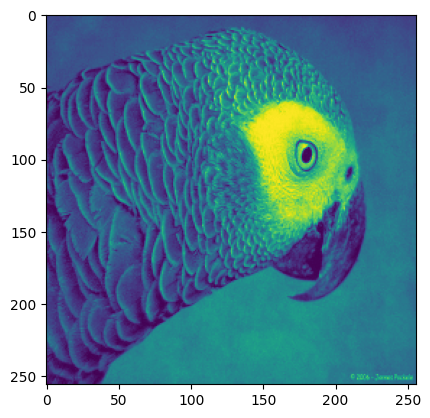

original copy of the image:


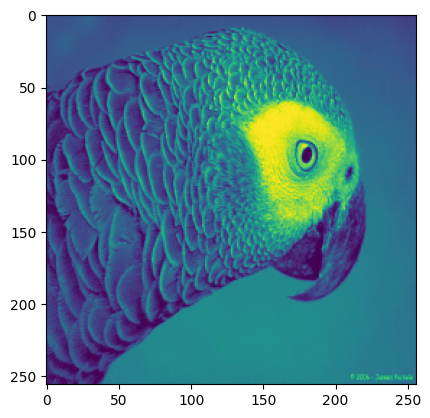

In [55]:
print(f"image number: {rnd % len(questions)}")
print("image remembered by memorizer:\n")
display_image(memorizer(questions[rnd % len(questions)]).cpu().detach())
print("original copy of the image:")
display_image(answers[rnd % len(questions)].cpu())

rnd += 1